In [1]:
import sys
sys.path.append('..')
import statistics
from collections import defaultdict
%reload_ext autoreload

%autoreload 2
import numpy as np
from models.NLP_only_models import lstm
import torch
from collections import defaultdict
import scipy.stats as st
import matplotlib.pyplot as plt


In [2]:
# FILES TO CHANGE (This is where your sequence_nlp_harvey.zip etc is) 

NPY_INPUT_DIR = '../data/extracted_features/combined_ML/maria/'
NPY_OUTPUT_DIR = '../data/resultsNLP/maria/'

NUM_TESTS = 25

HIDDEN_DIM0 = 183
NUM_LAYERS0 = 1
BIDIRECTIONAL = False
LEARNING_RATE0 =  0.011095843396210794
MOMENTUM0= 0.488375994822428
DECAY_FACTOR0 = 0.18991100364301827
EPOCH0 = 4

HIDDEN_DIM1 = 364
NUM_LAYERS1 = 1
ACTIVATION1 = torch.relu
LEARNING_RATE1 =  0.015103711963967328
MOMENTUM1= 0.2094525986367598
DECAY_FACTOR1 =  0.3093059390000923
EPOCH1 = 2

HIDDEN_DIM2 = 197
NUM_LAYERS2 = 2
ACTIVATION2 = torch.relu
LEARNING_RATE2 =  0.030727178086089976
MOMENTUM2= 0.5314758594296131
DECAY_FACTOR2 =  0.7632100704986595
EPOCH2 = 2

# LSTM -------------------------------------------------------------------*

In [3]:

def plot_cis(binNames, binRatios, priors):
    '''
    Requires a list of group str outputs and bin ratios from get_accuracy_graph - one for each run
    Collect results of both get_accuracy_plot return values -- names and binRatios-- in an array to run this.
    '''
    priors = np.array(priors[0])
    binVals = defaultdict(list)
    for run in range(len(binRatios)):
        for bin in range(len(binRatios[run])):
            binVals[bin+1].append(binRatios[run][bin]) # append the ratio (accuracy) of the bin to list
    cis = []
    means = []
    keys = []
    binLabels = [name for name in binNames[0]]
    for bin in binVals: # Calculate mean and CI for each bin
        keys.append(bin)
        mean = np.mean(binVals[bin])
        means.append(mean)
        standard = statistics.stdev(binVals[bin])
        cis.append(standard)
    plt.figure()  # initiate accuracy plot
    plt.plot(keys, means, label="Mean Accuracy by Bin")  # plot accuracy by bin
    plt.plot(keys, priors, label="Naive Accuracy")
    plt.errorbar(keys, means, yerr=cis)
    plt.xticks(keys, binLabels)
    plt.suptitle('Test classification accuracy rate by user history length (CI .95)')
    plt.xlabel('User history length (lowest to highest), sorted into bins (ascending order)')
    plt.ylabel('Accuracy rate')
    plt.show()
    return


def test_100(X_train, y_train, X_test, y_test):
    running_acc = 0.0
    running_auc = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    all_results = []
    
    HIDDEN_DIM0 = 364

    for i in range(NUM_TESTS):
        print('starting *********************************', i)
        model = lstm.LSTM(input_dim = 400, hidden_dim = HIDDEN_DIM0, num_layers = NUM_LAYERS0,
                          bidirectional = BIDIRECTIONAL, learning_rate = LEARNING_RATE0,
                          momentum = MOMENTUM0, decay_factor = DECAY_FACTOR0)
        model.learn(X_train, y_train, epochs=EPOCH0)
        
        # evaluate
        
        acc, auc, precision, recall, f1 = model.get_acc_auc_pre_re_f1(X_test, y_test)
        all_results.append([acc, auc, f1, precision, recall])
        running_acc += acc
        running_auc += auc
        running_f1 += f1
        running_precision += precision
        running_recall += recall
        bins, accRates, priors = model.get_accuracy_graph(X_test, y_test, y_train.numpy())
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    results = np.vstack(all_results)
    np.save(NPY_OUTPUT_DIR + 'lstm_results.npy', results)

    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, running_f1/NUM_TESTS, \
           running_precision/NUM_TESTS, running_recall/NUM_TESTS, \
           bin_names, graph_results, priors_list

In [4]:
# load data from files

X_seq_tfidf_train = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_train.npz')
X_seq_tfidf_test = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_test.npz')


X_seq_glove_train = np.load(NPY_INPUT_DIR + 'X_seq_glove_train.npz')
X_seq_glove_test = np.load(NPY_INPUT_DIR + 'X_seq_glove_test.npz')

y_train = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_train.npy'))
y_test = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_test.npy'))

# format npz objects as lists of arrays again
X_tfidf_train = [ torch.Tensor(X_seq_tfidf_train[file]) for file in X_seq_tfidf_train.files]
X_tfidf_test = [ torch.Tensor(X_seq_tfidf_test[file]) for file in X_seq_tfidf_test.files]

X_glove_train = [ torch.Tensor(X_seq_glove_train[file]) for file in X_seq_glove_train.files]
X_glove_test = [ torch.Tensor(X_seq_glove_test[file]) for file in X_seq_glove_test.files]


# build lists with features concatenated

from sklearn.preprocessing import StandardScaler

X_raw_train = []
for i in range(len(y_train)):
    file = X_seq_tfidf_train.files[i]
    X_raw_train.append(np.concatenate((X_seq_tfidf_train[file], X_seq_glove_train[file]), axis=1))

scaler = StandardScaler()
X_fit_train = np.concatenate(X_raw_train)
scaler.fit(X_fit_train)

X_train = [torch.Tensor(scaler.transform(X_i)) for X_i in X_raw_train]

X_test = []
for i in range(len(y_test)):
    file = X_seq_tfidf_test.files[i]
    X_test.append(torch.Tensor(scaler.transform(np.concatenate((X_seq_tfidf_test[file], X_seq_glove_test[file]), axis=1))))


starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.09523809523809523
R2 score for bin 1 = -0.13757802746566794
R2 score for bin 2 = -0.1404255319148935
R2 score for bin 3 = 0.32999999999999996
R2 score for bin 4 = -0.030769230769230882
R2 score for bin 5 = -0.41412788751255425
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


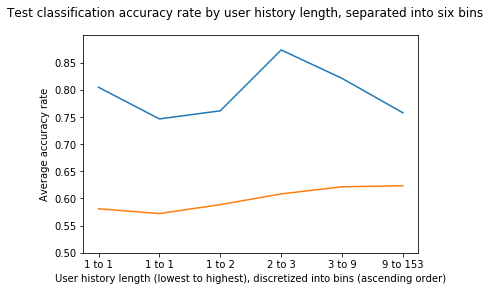

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.09523809523809523
R2 score for bin 1 = -0.104119850187266
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.21176470588235297
R2 score for bin 4 = -0.1166666666666667
R2 score for bin 5 = -0.41412788751255425
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


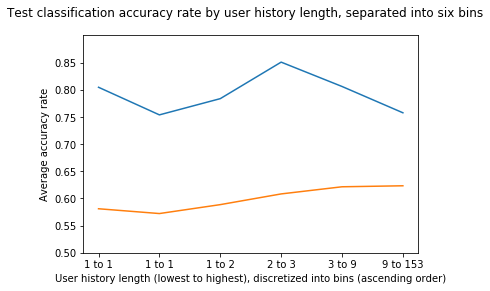

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.09523809523809523
R2 score for bin 1 = -0.07066167290886383
R2 score for bin 2 = -0.1404255319148935
R2 score for bin 3 = 0.25117647058823533
R2 score for bin 4 = -0.1166666666666667
R2 score for bin 5 = -0.36993639102778686
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


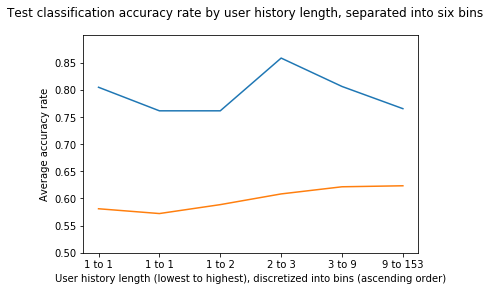

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.02564102564102566
R2 score for bin 1 = -0.13757802746566794
R2 score for bin 2 = -0.10478723404255308
R2 score for bin 3 = 0.32999999999999996
R2 score for bin 4 = -0.1166666666666667
R2 score for bin 5 = -0.2815533980582523
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


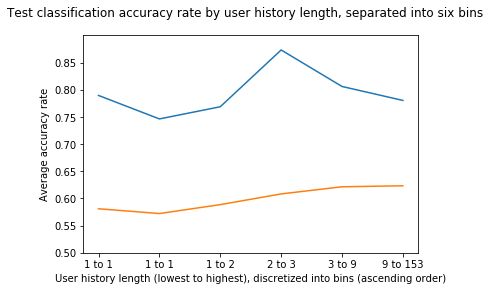

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.09523809523809523
R2 score for bin 1 = -0.104119850187266
R2 score for bin 2 = -0.10478723404255308
R2 score for bin 3 = 0.25117647058823533
R2 score for bin 4 = -0.030769230769230882
R2 score for bin 5 = -0.2815533980582523
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


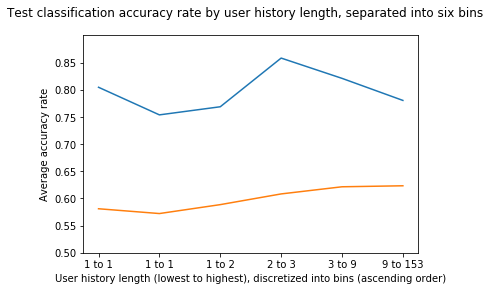

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.02564102564102566
R2 score for bin 1 = -0.1710362047440699
R2 score for bin 2 = -0.1760638297872339
R2 score for bin 3 = 0.25117647058823533
R2 score for bin 4 = 0.012179487179487136
R2 score for bin 5 = -0.36993639102778686
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


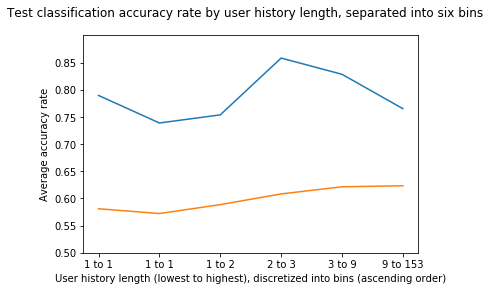

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.06043956043956045
R2 score for bin 1 = -0.13757802746566794
R2 score for bin 2 = -0.10478723404255308
R2 score for bin 3 = 0.36941176470588233
R2 score for bin 4 = -0.0737179487179489
R2 score for bin 5 = -0.2815533980582523
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


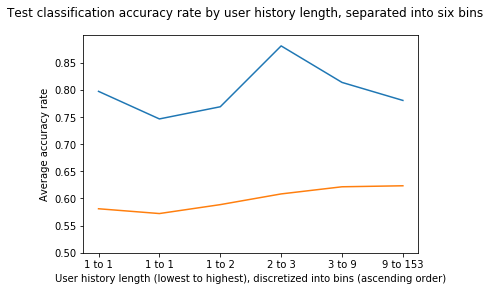

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.02564102564102566
R2 score for bin 1 = -0.13757802746566794
R2 score for bin 2 = -0.10478723404255308
R2 score for bin 3 = 0.2905882352941176
R2 score for bin 4 = -0.1166666666666667
R2 score for bin 5 = -0.2815533980582523
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


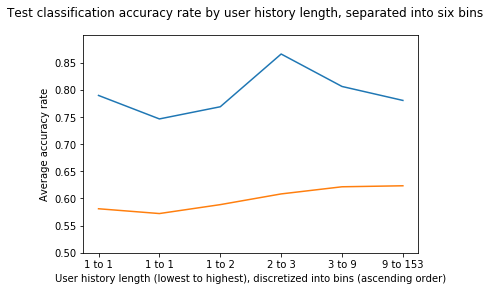

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.06043956043956045
R2 score for bin 1 = -0.104119850187266
R2 score for bin 2 = -0.06914893617021267
R2 score for bin 3 = 0.1723529411764706
R2 score for bin 4 = 0.012179487179487136
R2 score for bin 5 = -0.2815533980582523
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


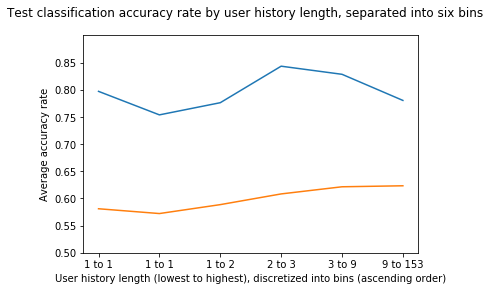

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = -0.009157509157509125
R2 score for bin 1 = -0.13757802746566794
R2 score for bin 2 = -0.10478723404255308
R2 score for bin 3 = 0.1723529411764706
R2 score for bin 4 = -0.030769230769230882
R2 score for bin 5 = -0.36993639102778686
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


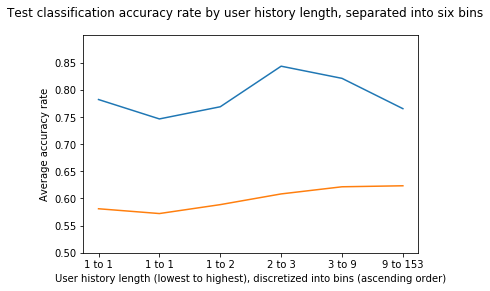

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = -0.009157509157509125
R2 score for bin 1 = -0.13757802746566794
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.21176470588235297
R2 score for bin 4 = -0.15961538461538471
R2 score for bin 5 = -0.32574489454301947
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


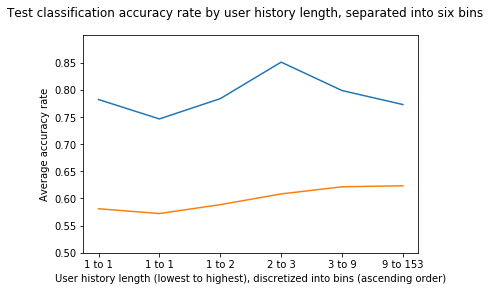

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.09523809523809523
R2 score for bin 1 = -0.07066167290886383
R2 score for bin 2 = -0.10478723404255308
R2 score for bin 3 = 0.21176470588235297
R2 score for bin 4 = -0.0737179487179489
R2 score for bin 5 = -0.32574489454301947
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


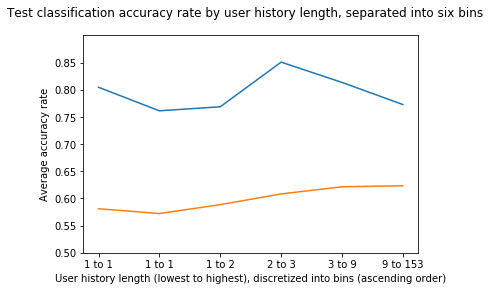

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.02564102564102566
R2 score for bin 1 = -0.13757802746566794
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.2905882352941176
R2 score for bin 4 = -0.15961538461538471
R2 score for bin 5 = -0.32574489454301947
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


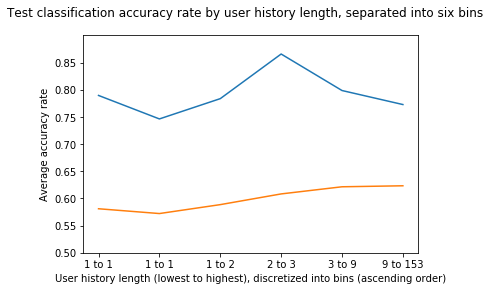

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.06043956043956045
R2 score for bin 1 = -0.104119850187266
R2 score for bin 2 = -0.1404255319148935
R2 score for bin 3 = 0.2905882352941176
R2 score for bin 4 = -0.0737179487179489
R2 score for bin 5 = -0.32574489454301947
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


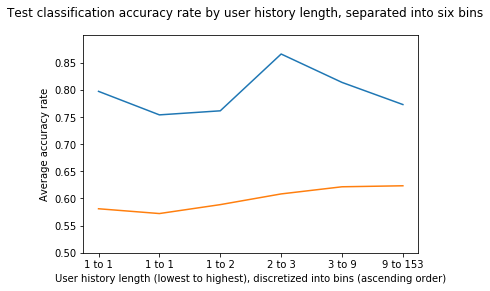

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.06043956043956045
R2 score for bin 1 = -0.104119850187266
R2 score for bin 2 = -0.06914893617021267
R2 score for bin 3 = 0.21176470588235297
R2 score for bin 4 = -0.030769230769230882
R2 score for bin 5 = -0.36993639102778686
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


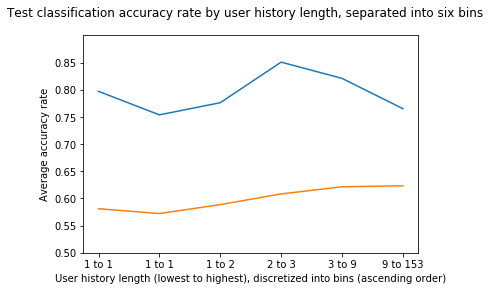

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.06043956043956045
R2 score for bin 1 = -0.13757802746566794
R2 score for bin 2 = -0.1404255319148935
R2 score for bin 3 = 0.25117647058823533
R2 score for bin 4 = -0.1166666666666667
R2 score for bin 5 = -0.36993639102778686
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


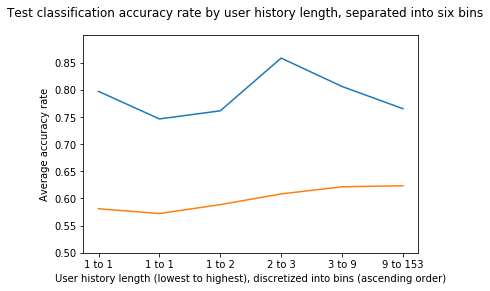

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.09523809523809523
R2 score for bin 1 = 0.029712858926342012
R2 score for bin 2 = -0.1404255319148935
R2 score for bin 3 = 0.2905882352941176
R2 score for bin 4 = -0.1166666666666667
R2 score for bin 5 = -0.36993639102778686
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


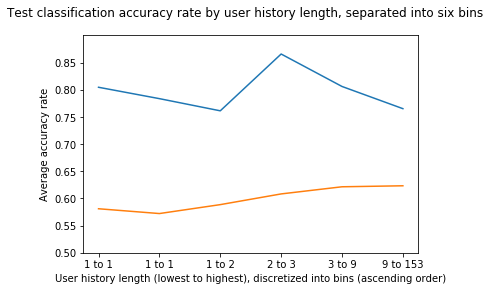

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.06043956043956045
R2 score for bin 1 = -0.104119850187266
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.25117647058823533
R2 score for bin 4 = -0.030769230769230882
R2 score for bin 5 = -0.41412788751255425
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


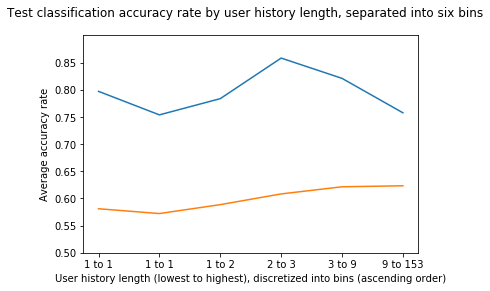

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.06043956043956045
R2 score for bin 1 = -0.104119850187266
R2 score for bin 2 = -0.10478723404255308
R2 score for bin 3 = 0.25117647058823533
R2 score for bin 4 = -0.030769230769230882
R2 score for bin 5 = -0.2815533980582523
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


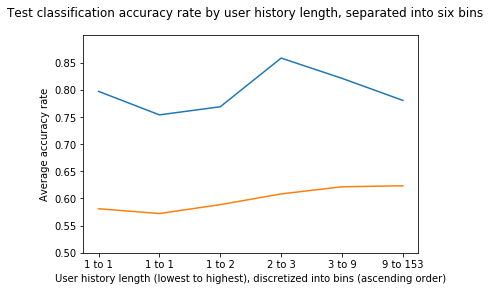

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.09523809523809523
R2 score for bin 1 = -0.104119850187266
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.25117647058823533
R2 score for bin 4 = 0.012179487179487136
R2 score for bin 5 = -0.36993639102778686
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


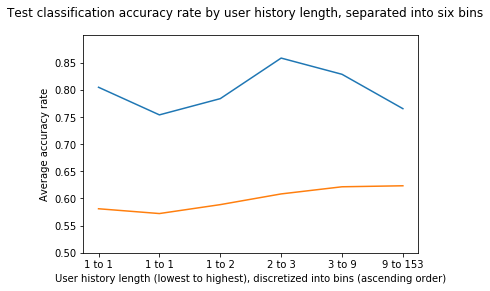

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.06043956043956045
R2 score for bin 1 = -0.104119850187266
R2 score for bin 2 = -0.06914893617021267
R2 score for bin 3 = 0.32999999999999996
R2 score for bin 4 = 0.012179487179487136
R2 score for bin 5 = -0.2373619015734849
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


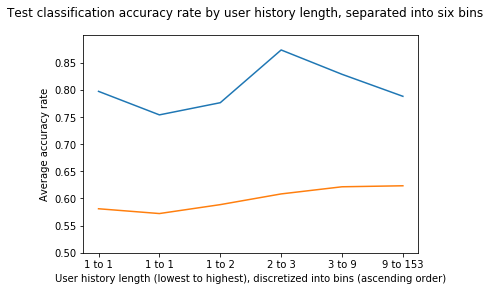

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.06043956043956045
R2 score for bin 1 = -0.13757802746566794
R2 score for bin 2 = -0.10478723404255308
R2 score for bin 3 = 0.2905882352941176
R2 score for bin 4 = -0.1166666666666667
R2 score for bin 5 = -0.32574489454301947
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


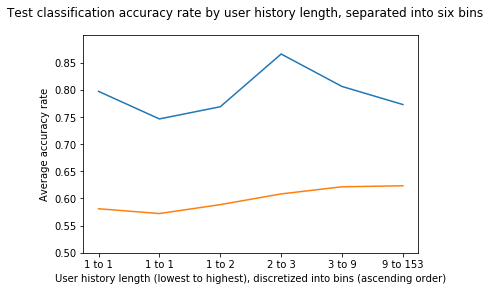

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.06043956043956045
R2 score for bin 1 = -0.13757802746566794
R2 score for bin 2 = -0.033510638297872264
R2 score for bin 3 = 0.32999999999999996
R2 score for bin 4 = -0.030769230769230882
R2 score for bin 5 = -0.2815533980582523
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


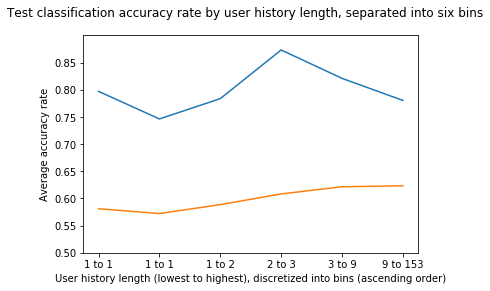

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.02564102564102566
R2 score for bin 1 = -0.1710362047440699
R2 score for bin 2 = -0.06914893617021267
R2 score for bin 3 = 0.25117647058823533
R2 score for bin 4 = -0.1166666666666667
R2 score for bin 5 = -0.36993639102778686
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


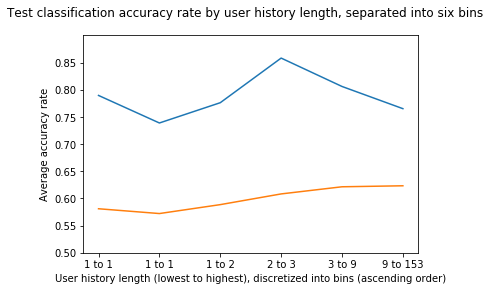

starting ********************************* 1
epoch: 0 learning rate: [0.011095843396210794]
epoch: 1 learning rate: [0.0021072227556401483]
epoch: 2 learning rate: [0.00040018478842302727]
epoch: 3 learning rate: [7.599949481208601e-05]
R2 score for bin 0 = 0.02564102564102566
R2 score for bin 1 = -0.13757802746566794
R2 score for bin 2 = -0.10478723404255308
R2 score for bin 3 = 0.25117647058823533
R2 score for bin 4 = -0.1166666666666667
R2 score for bin 5 = -0.32574489454301947
True proportion of + scores in bin 0 = 0.6842105263157895
True proportion of + scores in bin 1 = 0.664179104477612
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.746268656716418
True proportion of + scores in bin 4 = 0.7761194029850746
True proportion of + scores in bin 5 = 0.7803030303030303


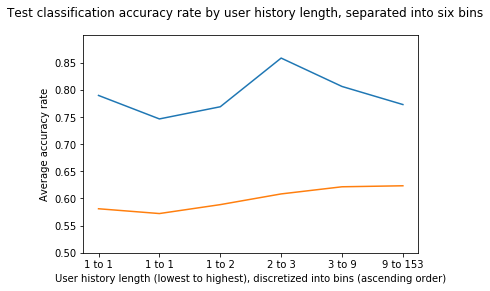

In [5]:

acc, auc, f1, precision, recall, bin_names, graph_results, priors_list = test_100(X_train,y_train,X_test,y_test)

Acc: 0.7941073657927591
AUC: 0.8354501642935378
F1: 0.8654217313846424
Precision: 0.8228046603179222
Recall: 0.9127022375215147


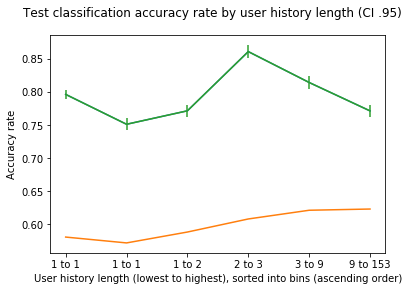

In [6]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
plot_cis(bin_names, graph_results, priors_list)

# BASELINE -------------------------------------------------------------------*

In [7]:
from collections import defaultdict
from models import baseline_mlp
import numpy as np
import torch
from sklearn.metrics import roc_auc_score
import statistics
import matplotlib.pyplot as plt

GLOVE_DIR = NPY_INPUT_DIR
TFIDF_DIR = NPY_INPUT_DIR

# with histories

In [8]:
def test_100(X_train, y_train, X_test, y_test, X_hist_len_test):
    running_acc = 0.0
    running_auc = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    all_results = []
    
    for i in range(NUM_TESTS):
        # make model
        baseline = baseline_mlp.MLP(X_train.shape[1], hidden_dim = HIDDEN_DIM1, num_layers= NUM_LAYERS1,
                                    activation_function = ACTIVATION1, learning_rate =  LEARNING_RATE1,
                                    momentum = MOMENTUM1, decay_factor = DECAY_FACTOR1)
        
        # train
        baseline.learn(torch.Tensor(X_train), torch.Tensor(y_train), epochs = EPOCH1)
        
        # evaluate
        acc, auc, precision, recall, f1 = baseline.get_acc_auc_pre_re_f1(torch.Tensor(X_test), torch.Tensor(y_test))

        running_acc += acc
        running_auc += auc
        running_f1 += f1
        running_precision += precision
        running_recall += recall
        all_results.append([acc, auc, f1, precision, recall])
        bins, accRates, priors = baseline.get_accuracy_graph(torch.Tensor(X_test), torch.Tensor(y_test),
                                                             X_hist_len_test, y_train)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    results = np.vstack(all_results)
    np.save(NPY_OUTPUT_DIR + 'history_baseline_results.npy', results)
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, running_f1/NUM_TESTS, \
           running_precision/NUM_TESTS, running_recall/NUM_TESTS, \
           bin_names, graph_results, priors_list

In [9]:
# retieve test data history sequence lengths from LSTM data
X_hist_len_test = np.load(NPY_INPUT_DIR + 'full_hist_lens_test.npy')

# load features
X_labeled_train_glove = np.load(GLOVE_DIR + 'X_labeled_train.npy')
X_histories_train_glove = np.load(GLOVE_DIR + 'X_histories_train.npy')
X_labeled_test_glove = np.load(GLOVE_DIR + 'X_labeled_test.npy')
X_histories_test_glove = np.load(GLOVE_DIR + 'X_histories_test.npy')
 
y_train = np.load(NPY_INPUT_DIR + 'y_train.npy')
y_test = np.load(NPY_INPUT_DIR + 'y_test.npy')

X_labeled_train_tfidf = np.load(TFIDF_DIR + 'trainTweets.npy')
X_histories_train_tfidf = np.load(TFIDF_DIR + 'trainHistories.npy')
X_labeled_test_tfidf = np.load(TFIDF_DIR + 'testTweets.npy')
X_histories_test_tfidf = np.load(TFIDF_DIR + 'testHistories.npy')

y_train_tfidf = np.load(TFIDF_DIR + 'trainClassifications.npy')
y_test_tfidf = np.load(TFIDF_DIR + 'testClassifications.npy')


# Normalized

from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
scaler4 = StandardScaler()


# TODO FIX NAMES!           
X_labeled_train_glove_norm    = scaler1.fit_transform(X_labeled_train_glove)
X_histories_train_glove_norm  = scaler2.fit_transform(X_histories_train_glove)
X_labeled_test_glove_norm     = scaler1.transform(X_labeled_test_glove)
X_histories_test_glove_norm  = scaler2.transform(X_histories_test_glove)

X_labeled_train_tfidf_norm    = scaler3.fit_transform(X_labeled_train_tfidf)
X_histories_train_tfidf_norm  = scaler4.fit_transform(X_histories_train_tfidf)
X_labeled_test_tfidf_norm     = scaler3.transform(X_labeled_test_tfidf)
X_histories_test_tfidf_norm   = scaler4.transform(X_histories_test_tfidf)

# merge data

X_train = np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm,
                          X_histories_train_glove_norm, X_histories_train_tfidf_norm),
                         axis = 1)
X_test = np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm,
                         X_histories_test_glove_norm, X_histories_test_tfidf_norm),
                        axis = 1)


epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.574
[1,   400] loss: 0.472
[1,   600] loss: 0.456
[1,   800] loss: 0.440
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.369
[2,   400] loss: 0.349
[2,   600] loss: 0.380
[2,   800] loss: 0.363
R2 score for bin 0 = 0.03855421686746996
R2 score for bin 1 = -0.1549033310039598
R2 score for bin 2 = 0.012471655328798126
R2 score for bin 3 = 0.02348178137651824
R2 score for bin 4 = -0.2929824561403511
R2 score for bin 5 = -0.19999999999999996
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


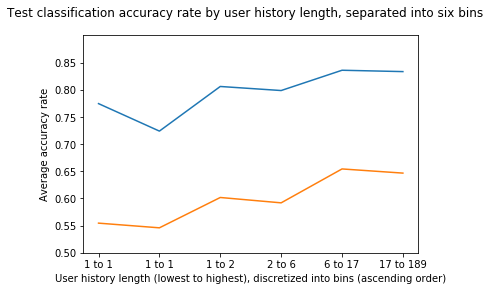

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.555
[1,   400] loss: 0.495
[1,   600] loss: 0.459
[1,   800] loss: 0.430
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.388
[2,   400] loss: 0.380
[2,   600] loss: 0.347
[2,   800] loss: 0.365
R2 score for bin 0 = 0.13469879518072292
R2 score for bin 1 = -0.24854414162590244
R2 score for bin 2 = -0.06349206349206349
R2 score for bin 3 = 0.13198380566801615
R2 score for bin 4 = -0.2929824561403511
R2 score for bin 5 = 0.0181818181818183
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


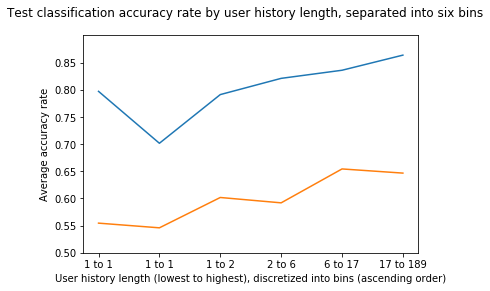

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.559
[1,   400] loss: 0.476
[1,   600] loss: 0.460
[1,   800] loss: 0.427
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.352
[2,   400] loss: 0.357
[2,   600] loss: 0.376
[2,   800] loss: 0.364
R2 score for bin 0 = 0.1667469879518073
R2 score for bin 1 = -0.27975774516655005
R2 score for bin 2 = 0.012471655328798126
R2 score for bin 3 = 0.05964912280701751
R2 score for bin 4 = -0.2929824561403511
R2 score for bin 5 = -0.2545454545454544
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


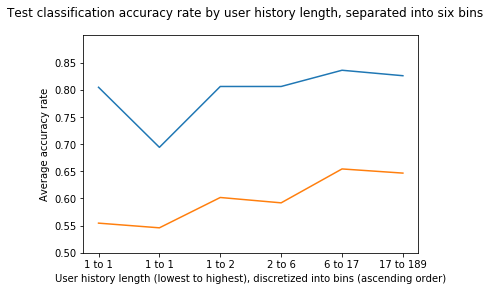

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.558
[1,   400] loss: 0.499
[1,   600] loss: 0.425
[1,   800] loss: 0.443
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.367
[2,   400] loss: 0.369
[2,   600] loss: 0.361
[2,   800] loss: 0.357
R2 score for bin 0 = -0.02554216867469883
R2 score for bin 1 = -0.24854414162590244
R2 score for bin 2 = -0.06349206349206349
R2 score for bin 3 = 0.09581646423751689
R2 score for bin 4 = -0.11666666666666692
R2 score for bin 5 = -0.14545454545454528
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


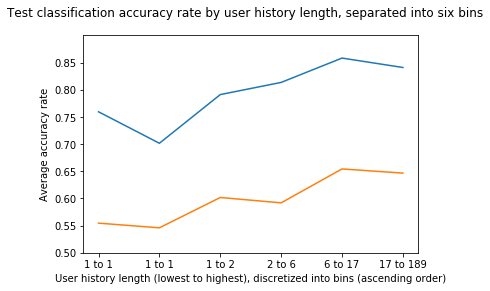

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.561
[1,   400] loss: 0.493
[1,   600] loss: 0.465
[1,   800] loss: 0.439
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.342
[2,   400] loss: 0.376
[2,   600] loss: 0.381
[2,   800] loss: 0.371
R2 score for bin 0 = 0.10265060240963864
R2 score for bin 1 = -0.21733053808525504
R2 score for bin 2 = -0.10147392290249435
R2 score for bin 3 = 0.09581646423751689
R2 score for bin 4 = -0.1754385964912284
R2 score for bin 5 = -0.19999999999999996
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


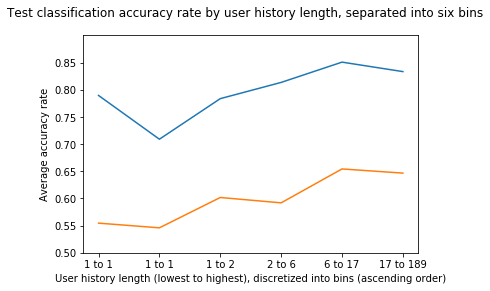

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.562
[1,   400] loss: 0.501
[1,   600] loss: 0.448
[1,   800] loss: 0.410
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.374
[2,   400] loss: 0.370
[2,   600] loss: 0.378
[2,   800] loss: 0.353
R2 score for bin 0 = 0.006506024096385565
R2 score for bin 1 = -0.21733053808525504
R2 score for bin 2 = 0.012471655328798126
R2 score for bin 3 = 0.09581646423751689
R2 score for bin 4 = -0.11666666666666692
R2 score for bin 5 = -0.19999999999999996
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


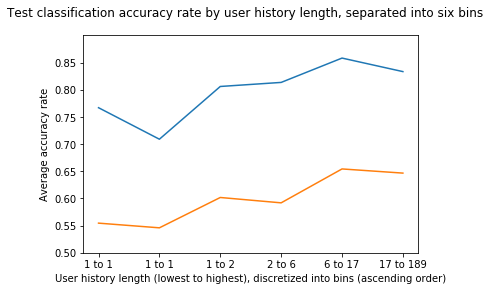

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.569
[1,   400] loss: 0.494
[1,   600] loss: 0.457
[1,   800] loss: 0.425
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.383
[2,   400] loss: 0.364
[2,   600] loss: 0.368
[2,   800] loss: 0.369
R2 score for bin 0 = 0.10265060240963864
R2 score for bin 1 = -0.1549033310039598
R2 score for bin 2 = -0.10147392290249435
R2 score for bin 3 = 0.05964912280701751
R2 score for bin 4 = -0.1754385964912284
R2 score for bin 5 = -0.09090909090909083
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


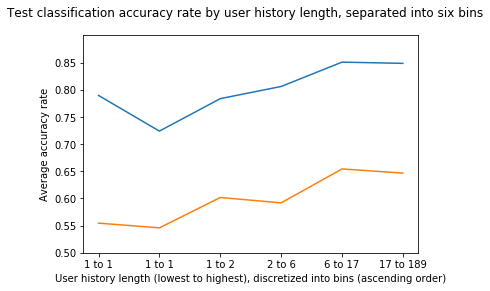

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.550
[1,   400] loss: 0.481
[1,   600] loss: 0.456
[1,   800] loss: 0.451
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.384
[2,   400] loss: 0.365
[2,   600] loss: 0.343
[2,   800] loss: 0.377
R2 score for bin 0 = -0.02554216867469883
R2 score for bin 1 = -0.21733053808525504
R2 score for bin 2 = -0.10147392290249435
R2 score for bin 3 = 0.05964912280701751
R2 score for bin 4 = -0.2929824561403511
R2 score for bin 5 = -0.09090909090909083
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


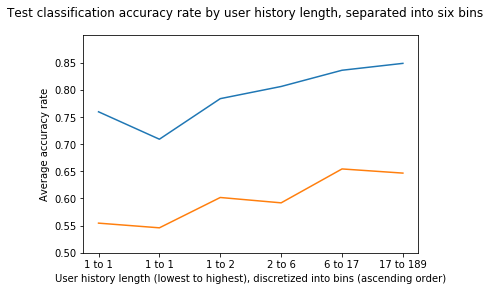

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.548
[1,   400] loss: 0.494
[1,   600] loss: 0.467
[1,   800] loss: 0.432
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.381
[2,   400] loss: 0.364
[2,   600] loss: 0.360
[2,   800] loss: 0.363
R2 score for bin 0 = -0.05759036144578311
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = -0.10147392290249435
R2 score for bin 3 = -0.012685560053981249
R2 score for bin 4 = -0.23421052631578965
R2 score for bin 5 = -0.09090909090909083
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


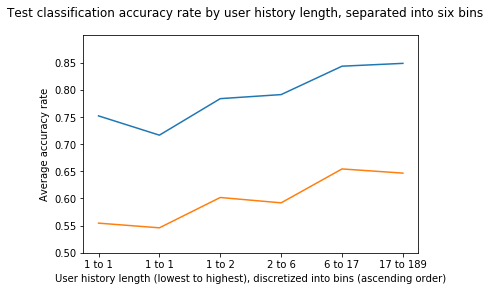

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.563
[1,   400] loss: 0.497
[1,   600] loss: 0.453
[1,   800] loss: 0.455
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.350
[2,   400] loss: 0.384
[2,   600] loss: 0.376
[2,   800] loss: 0.379
R2 score for bin 0 = -0.02554216867469883
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = -0.025510204081632626
R2 score for bin 3 = 0.05964912280701751
R2 score for bin 4 = -0.1754385964912284
R2 score for bin 5 = -0.14545454545454528
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


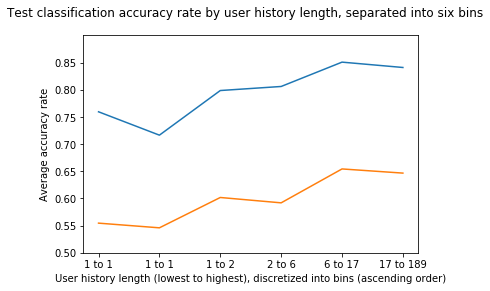

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.537
[1,   400] loss: 0.515
[1,   600] loss: 0.449
[1,   800] loss: 0.417
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.364
[2,   400] loss: 0.374
[2,   600] loss: 0.355
[2,   800] loss: 0.345
R2 score for bin 0 = 0.006506024096385565
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = -0.1394557823129252
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = -0.11666666666666692
R2 score for bin 5 = -0.036363636363636154
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


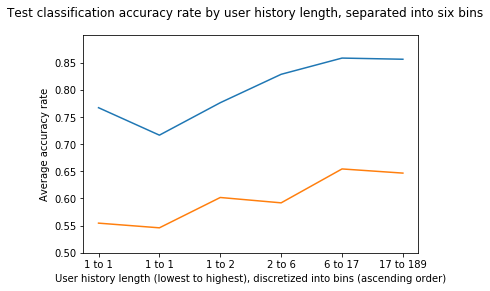

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.564
[1,   400] loss: 0.479
[1,   600] loss: 0.463
[1,   800] loss: 0.457
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.363
[2,   400] loss: 0.381
[2,   600] loss: 0.359
[2,   800] loss: 0.386
R2 score for bin 0 = 0.10265060240963864
R2 score for bin 1 = -0.21733053808525504
R2 score for bin 2 = -0.06349206349206349
R2 score for bin 3 = 0.09581646423751689
R2 score for bin 4 = -0.2929824561403511
R2 score for bin 5 = 0.07272727272727286
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


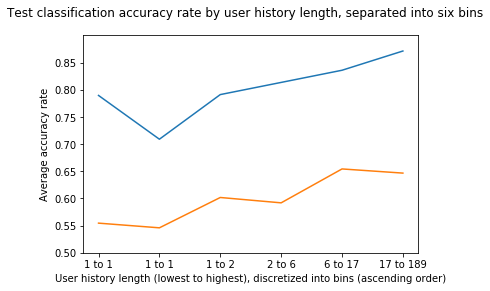

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.569
[1,   400] loss: 0.466
[1,   600] loss: 0.463
[1,   800] loss: 0.464
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.377
[2,   400] loss: 0.369
[2,   600] loss: 0.351
[2,   800] loss: 0.376
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.24854414162590244
R2 score for bin 2 = -0.025510204081632626
R2 score for bin 3 = 0.02348178137651824
R2 score for bin 4 = -0.1754385964912284
R2 score for bin 5 = -0.09090909090909083
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


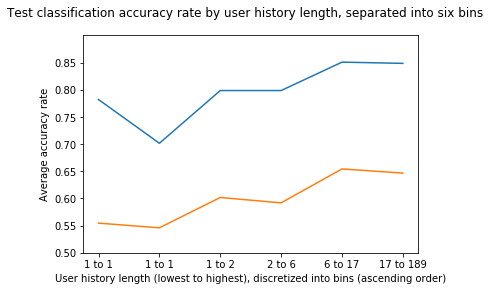

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.533
[1,   400] loss: 0.467
[1,   600] loss: 0.470
[1,   800] loss: 0.446
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.344
[2,   400] loss: 0.370
[2,   600] loss: 0.377
[2,   800] loss: 0.336
R2 score for bin 0 = 0.006506024096385565
R2 score for bin 1 = -0.24854414162590244
R2 score for bin 2 = -0.025510204081632626
R2 score for bin 3 = 0.02348178137651824
R2 score for bin 4 = -0.23421052631578965
R2 score for bin 5 = -0.036363636363636154
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


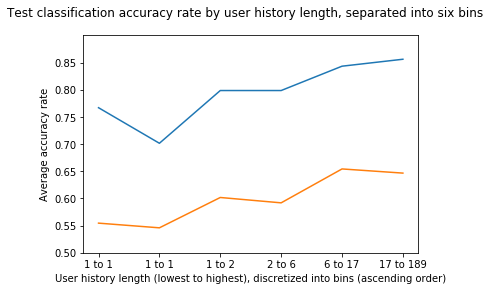

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.572
[1,   400] loss: 0.479
[1,   600] loss: 0.468
[1,   800] loss: 0.430
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.374
[2,   400] loss: 0.370
[2,   600] loss: 0.362
[2,   800] loss: 0.351
R2 score for bin 0 = 0.13469879518072292
R2 score for bin 1 = -0.1549033310039598
R2 score for bin 2 = 0.012471655328798126
R2 score for bin 3 = 0.05964912280701751
R2 score for bin 4 = -0.1754385964912284
R2 score for bin 5 = -0.09090909090909083
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


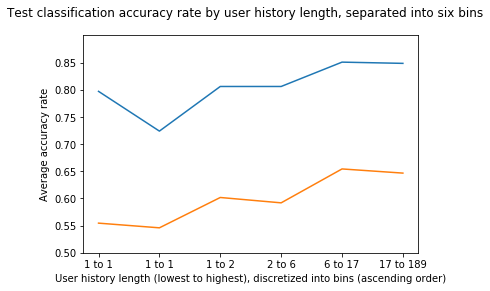

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.560
[1,   400] loss: 0.483
[1,   600] loss: 0.433
[1,   800] loss: 0.488
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.365
[2,   400] loss: 0.372
[2,   600] loss: 0.381
[2,   800] loss: 0.361
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = 0.012471655328798126
R2 score for bin 3 = 0.05964912280701751
R2 score for bin 4 = -0.11666666666666692
R2 score for bin 5 = 0.0181818181818183
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


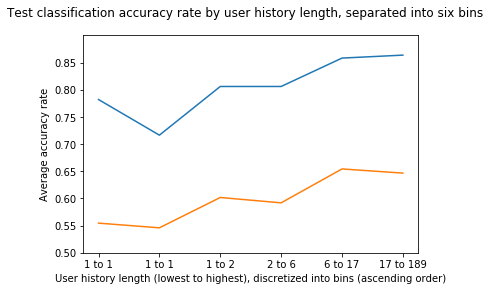

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.560
[1,   400] loss: 0.469
[1,   600] loss: 0.466
[1,   800] loss: 0.440
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.344
[2,   400] loss: 0.365
[2,   600] loss: 0.386
[2,   800] loss: 0.367
R2 score for bin 0 = 0.006506024096385565
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = -0.06349206349206349
R2 score for bin 3 = 0.02348178137651824
R2 score for bin 4 = -0.1754385964912284
R2 score for bin 5 = 0.0181818181818183
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


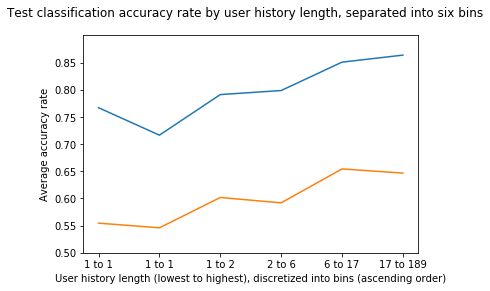

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.572
[1,   400] loss: 0.459
[1,   600] loss: 0.449
[1,   800] loss: 0.458
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.390
[2,   400] loss: 0.370
[2,   600] loss: 0.375
[2,   800] loss: 0.330
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.27975774516655005
R2 score for bin 2 = 0.012471655328798126
R2 score for bin 3 = -0.012685560053981249
R2 score for bin 4 = -0.23421052631578965
R2 score for bin 5 = 0.07272727272727286
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


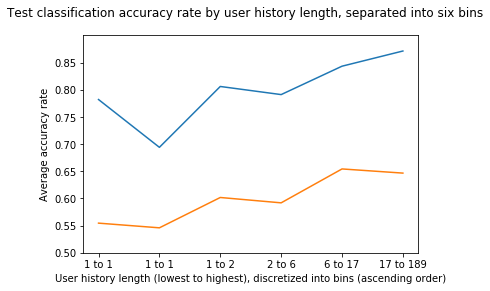

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.558
[1,   400] loss: 0.501
[1,   600] loss: 0.447
[1,   800] loss: 0.437
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.355
[2,   400] loss: 0.372
[2,   600] loss: 0.378
[2,   800] loss: 0.362
R2 score for bin 0 = -0.02554216867469883
R2 score for bin 1 = -0.21733053808525504
R2 score for bin 2 = -0.1394557823129252
R2 score for bin 3 = 0.02348178137651824
R2 score for bin 4 = -0.3517543859649126
R2 score for bin 5 = -0.19999999999999996
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


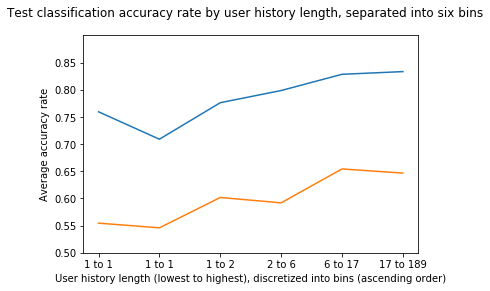

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.548
[1,   400] loss: 0.488
[1,   600] loss: 0.467
[1,   800] loss: 0.435
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.370
[2,   400] loss: 0.372
[2,   600] loss: 0.362
[2,   800] loss: 0.364
R2 score for bin 0 = 0.03855421686746996
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = 0.012471655328798126
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = -0.1754385964912284
R2 score for bin 5 = -0.09090909090909083
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


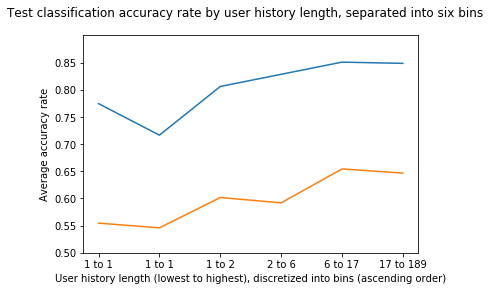

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.561
[1,   400] loss: 0.503
[1,   600] loss: 0.457
[1,   800] loss: 0.410
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.358
[2,   400] loss: 0.364
[2,   600] loss: 0.365
[2,   800] loss: 0.380
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.1236897274633122
R2 score for bin 2 = -0.06349206349206349
R2 score for bin 3 = 0.13198380566801615
R2 score for bin 4 = -0.1754385964912284
R2 score for bin 5 = 0.0181818181818183
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


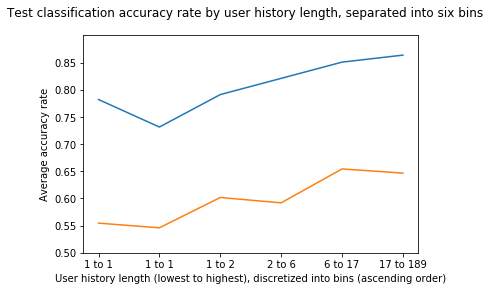

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.576
[1,   400] loss: 0.495
[1,   600] loss: 0.439
[1,   800] loss: 0.433
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.361
[2,   400] loss: 0.383
[2,   600] loss: 0.386
[2,   800] loss: 0.336
R2 score for bin 0 = 0.03855421686746996
R2 score for bin 1 = -0.1236897274633122
R2 score for bin 2 = -0.10147392290249435
R2 score for bin 3 = 0.05964912280701751
R2 score for bin 4 = -0.11666666666666692
R2 score for bin 5 = -0.036363636363636154
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


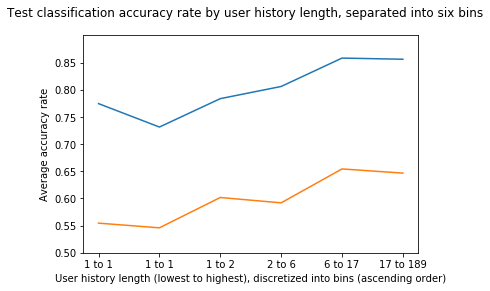

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.538
[1,   400] loss: 0.511
[1,   600] loss: 0.463
[1,   800] loss: 0.429
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.392
[2,   400] loss: 0.383
[2,   600] loss: 0.350
[2,   800] loss: 0.352
R2 score for bin 0 = 0.006506024096385565
R2 score for bin 1 = -0.27975774516655005
R2 score for bin 2 = -0.10147392290249435
R2 score for bin 3 = 0.13198380566801615
R2 score for bin 4 = -0.23421052631578965
R2 score for bin 5 = -0.14545454545454528
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


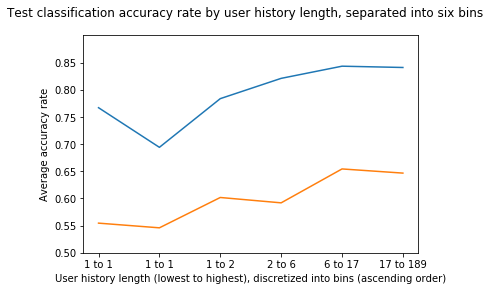

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.561
[1,   400] loss: 0.482
[1,   600] loss: 0.467
[1,   800] loss: 0.408
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.340
[2,   400] loss: 0.380
[2,   600] loss: 0.362
[2,   800] loss: 0.359
R2 score for bin 0 = -0.02554216867469883
R2 score for bin 1 = -0.1549033310039598
R2 score for bin 2 = -0.06349206349206349
R2 score for bin 3 = -0.08502024291497978
R2 score for bin 4 = -0.1754385964912284
R2 score for bin 5 = 0.0181818181818183
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


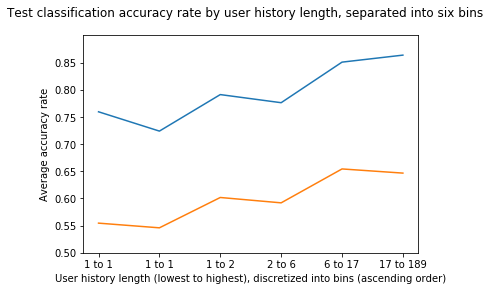

epoch: 0 learning rate: [0.015103711963967328]
[1,   200] loss: 0.552
[1,   400] loss: 0.490
[1,   600] loss: 0.446
[1,   800] loss: 0.453
epoch: 1 learning rate: [0.004671667811401842]
[2,   200] loss: 0.373
[2,   400] loss: 0.354
[2,   600] loss: 0.374
[2,   800] loss: 0.375
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = -0.025510204081632626
R2 score for bin 3 = 0.2043184885290148
R2 score for bin 4 = -0.11666666666666692
R2 score for bin 5 = -0.19999999999999996
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


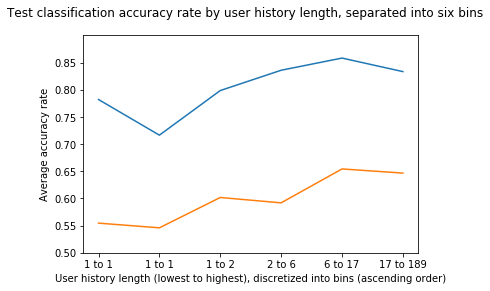

In [10]:
acc, auc, f1, precision, recall, bin_names, graph_results, priors_list= test_100(X_train,y_train,X_test,y_test, X_hist_len_test)

Acc: 0.7975530586766543
AUC: 0.8390297293068377
F1: 0.8689235222477368
Precision: 0.8191862206599351
Recall: 0.9252323580034424


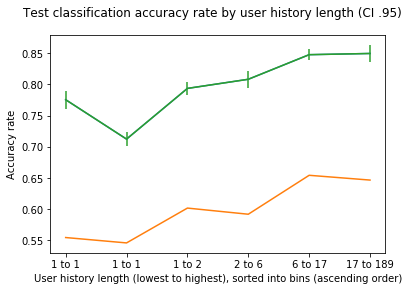

In [11]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
plot_cis(bin_names, graph_results, priors_list)

# without histories

In [12]:
def test_100(X_train, y_train, X_test, y_test, X_hist_len_test):
    running_acc = 0.0
    running_auc = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    running_recall = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    all_results = []
    
    for i in range(NUM_TESTS):
        # make model
        baseline = baseline_mlp.MLP(X_train.shape[1], hidden_dim = HIDDEN_DIM2, num_layers= NUM_LAYERS2,
                                    activation_function = ACTIVATION2, learning_rate =  LEARNING_RATE2,
                                    momentum = MOMENTUM2, decay_factor = DECAY_FACTOR2)
        
        # train
        baseline.learn(torch.Tensor(X_train), torch.Tensor(y_train), epochs = EPOCH2)
        
        # evaluate
        acc, auc, precision, recall, f1 = baseline.get_acc_auc_pre_re_f1(torch.Tensor(X_test), torch.Tensor(y_test))
        all_results.append([acc, auc, f1, precision, recall])
        running_acc += acc
        running_auc += auc
        running_f1 += f1
        running_precision += precision
        running_recall += recall
        bins, accRates, priors = baseline.get_accuracy_graph(torch.Tensor(X_test), torch.Tensor(y_test),
                                                             X_hist_len_test, y_train)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    #baseline.plot_cis(bin_names, graph_results)

    results = np.vstack(all_results)
    np.save(NPY_OUTPUT_DIR + 'nohistory_baseline_results.npy', results)
    return running_acc/NUM_TESTS, running_auc/NUM_TESTS, running_f1/NUM_TESTS, \
           running_precision/NUM_TESTS, running_recall/NUM_TESTS, \
           bin_names, graph_results, priors_list

In [13]:
# merge data

X_train = np.concatenate((X_labeled_train_glove_norm, X_labeled_train_tfidf_norm),
                         axis = 1)
X_test = np.concatenate((X_labeled_test_glove_norm, X_labeled_test_tfidf_norm),
                        axis = 1)

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.592
[1,   400] loss: 0.482
[1,   600] loss: 0.464
[1,   800] loss: 0.422
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.393
[2,   400] loss: 0.330
[2,   600] loss: 0.386
[2,   800] loss: 0.383
R2 score for bin 0 = 0.006506024096385565
R2 score for bin 1 = -0.21733053808525504
R2 score for bin 2 = -0.1394557823129252
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = -0.11666666666666692
R2 score for bin 5 = -0.2545454545454544
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


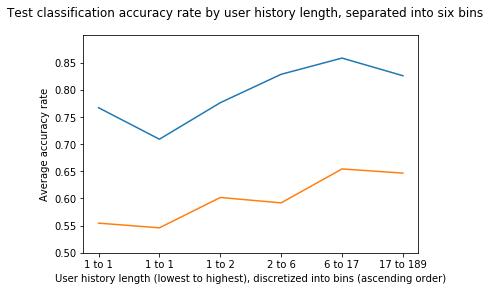

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.574
[1,   400] loss: 0.477
[1,   600] loss: 0.465
[1,   800] loss: 0.423
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.365
[2,   400] loss: 0.365
[2,   600] loss: 0.366
[2,   800] loss: 0.373
R2 score for bin 0 = 0.006506024096385565
R2 score for bin 1 = -0.0924761239226648
R2 score for bin 2 = -0.06349206349206349
R2 score for bin 3 = 0.24048582995951417
R2 score for bin 4 = -0.05789473684210544
R2 score for bin 5 = -0.36363636363636354
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


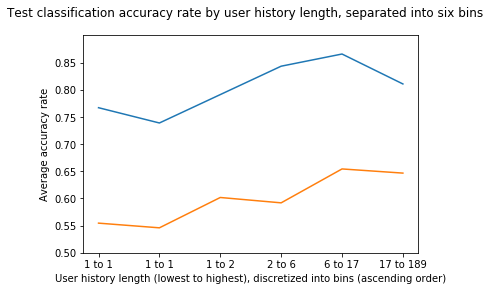

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.593
[1,   400] loss: 0.496
[1,   600] loss: 0.450
[1,   800] loss: 0.426
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.371
[2,   400] loss: 0.345
[2,   600] loss: 0.397
[2,   800] loss: 0.374
R2 score for bin 0 = -0.02554216867469883
R2 score for bin 1 = -0.24854414162590244
R2 score for bin 2 = -0.10147392290249435
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = -0.1754385964912284
R2 score for bin 5 = -0.47272727272727244
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


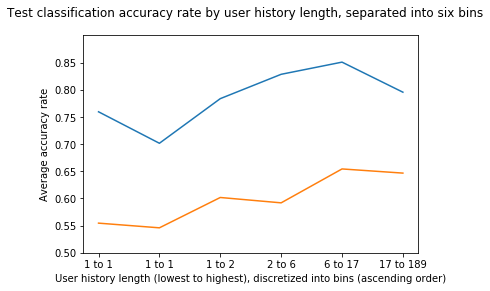

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.589
[1,   400] loss: 0.499
[1,   600] loss: 0.471
[1,   800] loss: 0.446
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.384
[2,   400] loss: 0.374
[2,   600] loss: 0.362
[2,   800] loss: 0.380
R2 score for bin 0 = 0.006506024096385565
R2 score for bin 1 = -0.21733053808525504
R2 score for bin 2 = -0.10147392290249435
R2 score for bin 3 = 0.02348178137651824
R2 score for bin 4 = -0.11666666666666692
R2 score for bin 5 = -0.30909090909090886
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


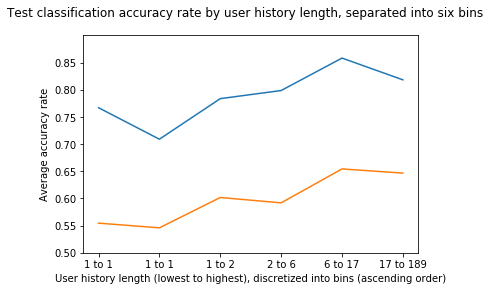

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.572
[1,   400] loss: 0.501
[1,   600] loss: 0.469
[1,   800] loss: 0.430
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.364
[2,   400] loss: 0.386
[2,   600] loss: 0.368
[2,   800] loss: 0.371
R2 score for bin 0 = 0.03855421686746996
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = -0.21541950113378694
R2 score for bin 3 = 0.2043184885290148
R2 score for bin 4 = -0.2929824561403511
R2 score for bin 5 = -0.09090909090909083
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


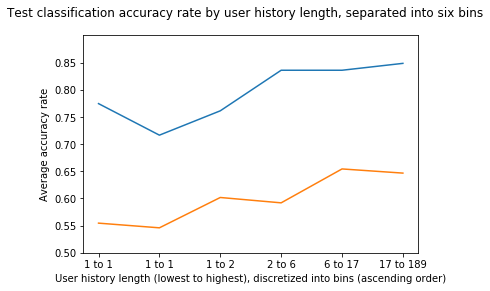

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.551
[1,   400] loss: 0.485
[1,   600] loss: 0.465
[1,   800] loss: 0.444
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.374
[2,   400] loss: 0.362
[2,   600] loss: 0.377
[2,   800] loss: 0.377
R2 score for bin 0 = 0.006506024096385565
R2 score for bin 1 = -0.21733053808525504
R2 score for bin 2 = -0.06349206349206349
R2 score for bin 3 = 0.13198380566801615
R2 score for bin 4 = -0.11666666666666692
R2 score for bin 5 = -0.2545454545454544
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


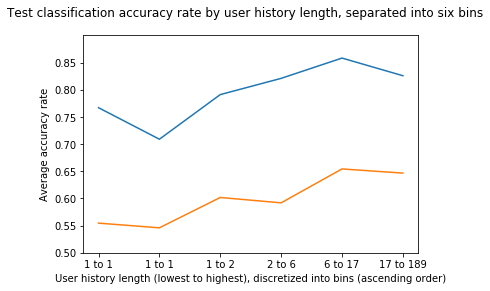

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.586
[1,   400] loss: 0.503
[1,   600] loss: 0.437
[1,   800] loss: 0.463
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.390
[2,   400] loss: 0.357
[2,   600] loss: 0.372
[2,   800] loss: 0.374
R2 score for bin 0 = -0.02554216867469883
R2 score for bin 1 = -0.24854414162590244
R2 score for bin 2 = -0.06349206349206349
R2 score for bin 3 = -0.048852901484480515
R2 score for bin 4 = 0.059649122807017396
R2 score for bin 5 = -0.2545454545454544
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


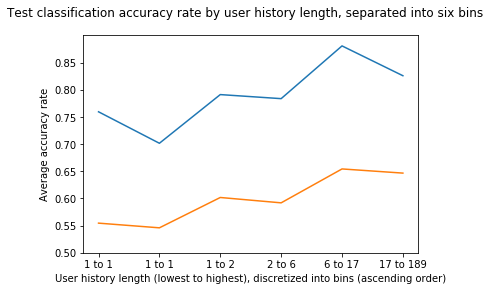

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.581
[1,   400] loss: 0.495
[1,   600] loss: 0.465
[1,   800] loss: 0.445
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.384
[2,   400] loss: 0.369
[2,   600] loss: 0.371
[2,   800] loss: 0.368
R2 score for bin 0 = -0.05759036144578311
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = 0.012471655328798126
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = -0.05789473684210544
R2 score for bin 5 = -0.19999999999999996
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


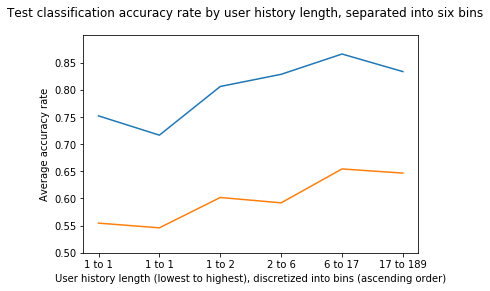

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.588
[1,   400] loss: 0.512
[1,   600] loss: 0.429
[1,   800] loss: 0.448
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.389
[2,   400] loss: 0.373
[2,   600] loss: 0.366
[2,   800] loss: 0.389
R2 score for bin 0 = 0.13469879518072292
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = -0.1394557823129252
R2 score for bin 3 = 0.2043184885290148
R2 score for bin 4 = -0.11666666666666692
R2 score for bin 5 = -0.36363636363636354
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


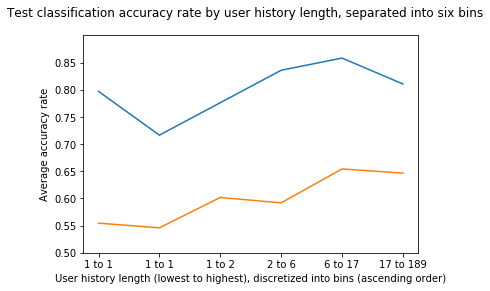

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.574
[1,   400] loss: 0.490
[1,   600] loss: 0.465
[1,   800] loss: 0.417
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.384
[2,   400] loss: 0.357
[2,   600] loss: 0.357
[2,   800] loss: 0.396
R2 score for bin 0 = 0.03855421686746996
R2 score for bin 1 = -0.27975774516655005
R2 score for bin 2 = -0.025510204081632626
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = 0.000877192982455921
R2 score for bin 5 = -0.2545454545454544
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


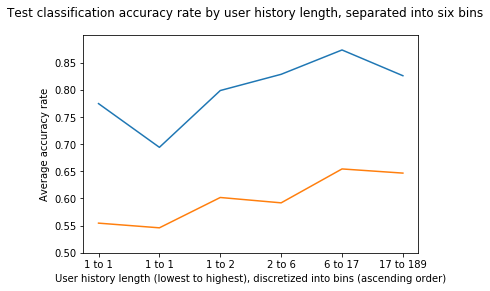

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.583
[1,   400] loss: 0.490
[1,   600] loss: 0.457
[1,   800] loss: 0.461
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.353
[2,   400] loss: 0.415
[2,   600] loss: 0.382
[2,   800] loss: 0.355
R2 score for bin 0 = 0.03855421686746996
R2 score for bin 1 = -0.27975774516655005
R2 score for bin 2 = 0.012471655328798126
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = 0.000877192982455921
R2 score for bin 5 = -0.2545454545454544
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


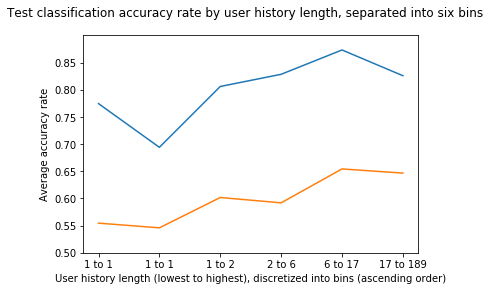

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.582
[1,   400] loss: 0.493
[1,   600] loss: 0.443
[1,   800] loss: 0.448
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.377
[2,   400] loss: 0.357
[2,   600] loss: 0.382
[2,   800] loss: 0.384
R2 score for bin 0 = 0.10265060240963864
R2 score for bin 1 = -0.27975774516655005
R2 score for bin 2 = -0.06349206349206349
R2 score for bin 3 = 0.13198380566801615
R2 score for bin 4 = -0.05789473684210544
R2 score for bin 5 = -0.30909090909090886
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


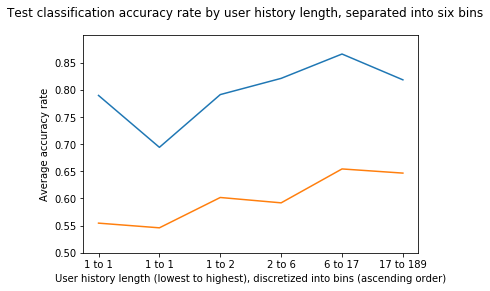

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.551
[1,   400] loss: 0.498
[1,   600] loss: 0.470
[1,   800] loss: 0.465
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.384
[2,   400] loss: 0.347
[2,   600] loss: 0.372
[2,   800] loss: 0.388
R2 score for bin 0 = 0.006506024096385565
R2 score for bin 1 = -0.24854414162590244
R2 score for bin 2 = -0.10147392290249435
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = 0.000877192982455921
R2 score for bin 5 = -0.14545454545454528
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


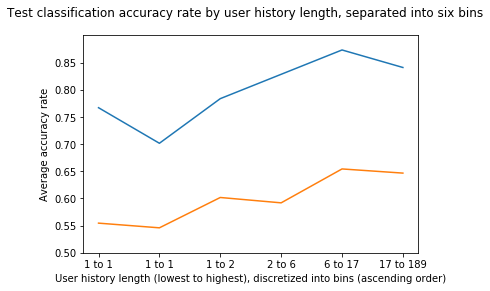

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.600
[1,   400] loss: 0.519
[1,   600] loss: 0.475
[1,   800] loss: 0.436
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.389
[2,   400] loss: 0.399
[2,   600] loss: 0.367
[2,   800] loss: 0.379
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.21733053808525504
R2 score for bin 2 = -0.06349206349206349
R2 score for bin 3 = 0.13198380566801615
R2 score for bin 4 = -0.05789473684210544
R2 score for bin 5 = -0.36363636363636354
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


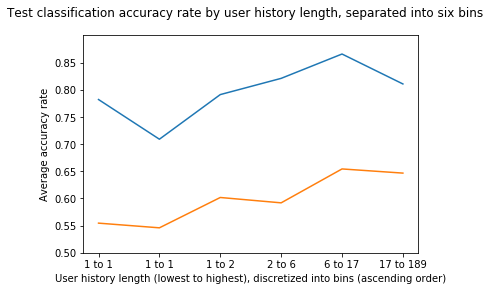

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.578
[1,   400] loss: 0.489
[1,   600] loss: 0.468
[1,   800] loss: 0.433
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.377
[2,   400] loss: 0.356
[2,   600] loss: 0.408
[2,   800] loss: 0.340
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.18611693454460743
R2 score for bin 2 = -0.025510204081632626
R2 score for bin 3 = 0.05964912280701751
R2 score for bin 4 = 0.11842105263157876
R2 score for bin 5 = -0.30909090909090886
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


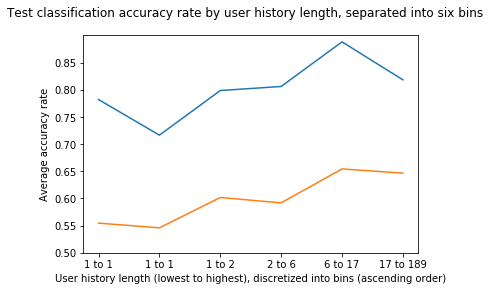

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.595
[1,   400] loss: 0.535
[1,   600] loss: 0.438
[1,   800] loss: 0.401
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.353
[2,   400] loss: 0.392
[2,   600] loss: 0.375
[2,   800] loss: 0.406
R2 score for bin 0 = -0.05759036144578311
R2 score for bin 1 = -0.1236897274633122
R2 score for bin 2 = -0.06349206349206349
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = -0.05789473684210544
R2 score for bin 5 = -0.19999999999999996
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


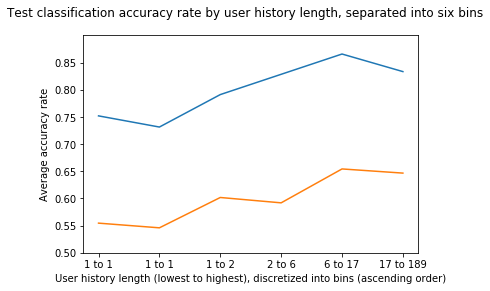

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.570
[1,   400] loss: 0.527
[1,   600] loss: 0.453
[1,   800] loss: 0.405
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.358
[2,   400] loss: 0.359
[2,   600] loss: 0.387
[2,   800] loss: 0.386
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.27975774516655005
R2 score for bin 2 = -0.025510204081632626
R2 score for bin 3 = 0.09581646423751689
R2 score for bin 4 = -0.05789473684210544
R2 score for bin 5 = -0.30909090909090886
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


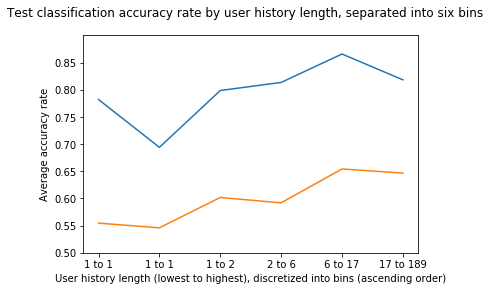

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.568
[1,   400] loss: 0.515
[1,   600] loss: 0.487
[1,   800] loss: 0.442
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.378
[2,   400] loss: 0.391
[2,   600] loss: 0.353
[2,   800] loss: 0.388
R2 score for bin 0 = 0.006506024096385565
R2 score for bin 1 = -0.27975774516655005
R2 score for bin 2 = -0.1394557823129252
R2 score for bin 3 = 0.24048582995951417
R2 score for bin 4 = -0.23421052631578965
R2 score for bin 5 = -0.2545454545454544
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


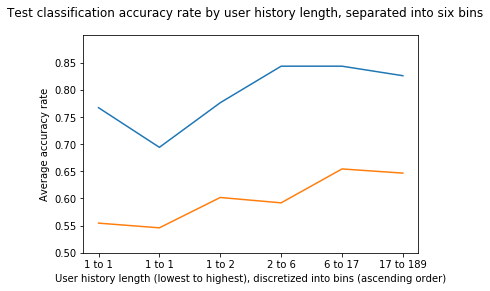

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.581
[1,   400] loss: 0.520
[1,   600] loss: 0.459
[1,   800] loss: 0.432
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.361
[2,   400] loss: 0.370
[2,   600] loss: 0.383
[2,   800] loss: 0.385
R2 score for bin 0 = -0.02554216867469883
R2 score for bin 1 = -0.31097134870719767
R2 score for bin 2 = 0.08843537414965985
R2 score for bin 3 = 0.24048582995951417
R2 score for bin 4 = 0.11842105263157876
R2 score for bin 5 = -0.30909090909090886
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


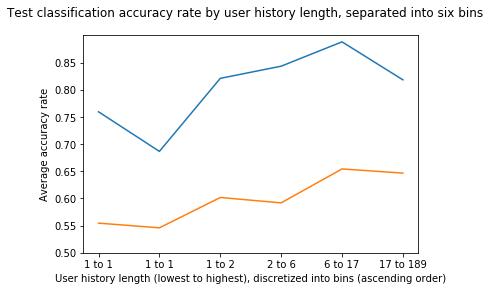

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.566
[1,   400] loss: 0.493
[1,   600] loss: 0.476
[1,   800] loss: 0.431
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.380
[2,   400] loss: 0.354
[2,   600] loss: 0.381
[2,   800] loss: 0.387
R2 score for bin 0 = 0.10265060240963864
R2 score for bin 1 = -0.21733053808525504
R2 score for bin 2 = -0.2534013605442178
R2 score for bin 3 = 0.16815114709851553
R2 score for bin 4 = -0.5280701754385968
R2 score for bin 5 = -0.19999999999999996
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


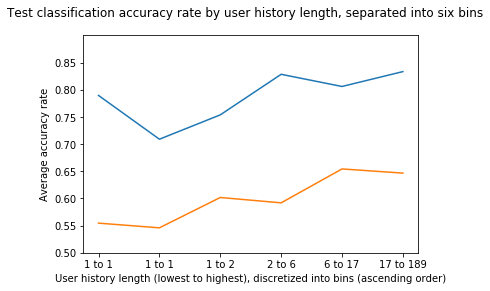

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.594
[1,   400] loss: 0.512
[1,   600] loss: 0.446
[1,   800] loss: 0.447
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.374
[2,   400] loss: 0.357
[2,   600] loss: 0.386
[2,   800] loss: 0.386
R2 score for bin 0 = -0.05759036144578311
R2 score for bin 1 = -0.3733985557884927
R2 score for bin 2 = -0.025510204081632626
R2 score for bin 3 = 0.13198380566801615
R2 score for bin 4 = -0.05789473684210544
R2 score for bin 5 = -0.19999999999999996
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


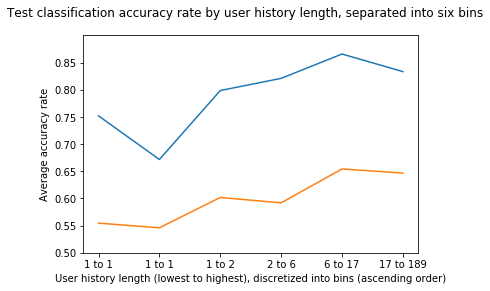

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.602
[1,   400] loss: 0.523
[1,   600] loss: 0.456
[1,   800] loss: 0.420
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.381
[2,   400] loss: 0.381
[2,   600] loss: 0.405
[2,   800] loss: 0.354
R2 score for bin 0 = -0.12168674698795168
R2 score for bin 1 = -0.3733985557884927
R2 score for bin 2 = -0.06349206349206349
R2 score for bin 3 = 0.05964912280701751
R2 score for bin 4 = 0.059649122807017396
R2 score for bin 5 = -0.2545454545454544
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


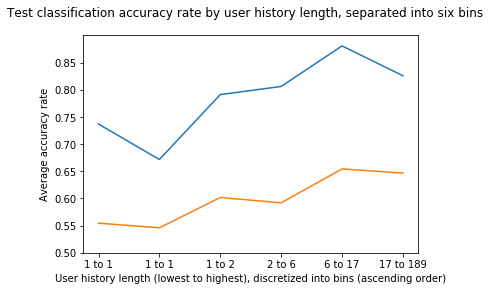

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.572
[1,   400] loss: 0.509
[1,   600] loss: 0.472
[1,   800] loss: 0.414
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.404
[2,   400] loss: 0.378
[2,   600] loss: 0.377
[2,   800] loss: 0.345
R2 score for bin 0 = 0.07060240963855424
R2 score for bin 1 = -0.24854414162590244
R2 score for bin 2 = 0.05045351473922899
R2 score for bin 3 = -0.048852901484480515
R2 score for bin 4 = -0.1754385964912284
R2 score for bin 5 = -0.2545454545454544
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


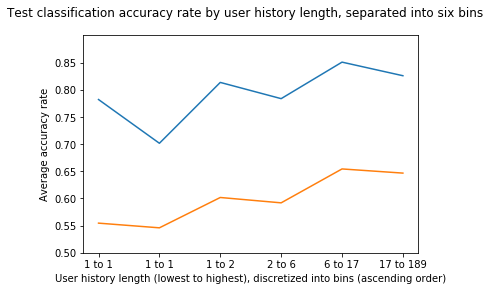

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.588
[1,   400] loss: 0.518
[1,   600] loss: 0.479
[1,   800] loss: 0.454
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.392
[2,   400] loss: 0.367
[2,   600] loss: 0.410
[2,   800] loss: 0.364
R2 score for bin 0 = 0.006506024096385565
R2 score for bin 1 = -0.27975774516655005
R2 score for bin 2 = -0.10147392290249435
R2 score for bin 3 = -0.012685560053981249
R2 score for bin 4 = 0.000877192982455921
R2 score for bin 5 = -0.19999999999999996
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


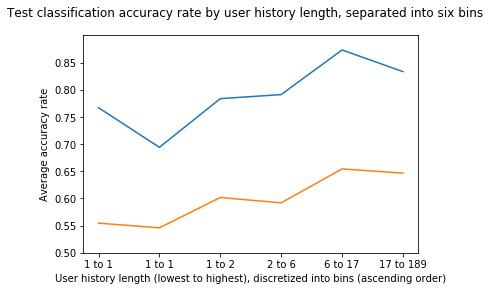

epoch: 0 learning rate: [0.030727178086089976]
[1,   200] loss: 0.575
[1,   400] loss: 0.501
[1,   600] loss: 0.443
[1,   800] loss: 0.487
epoch: 1 learning rate: [0.023451291753309598]
[2,   200] loss: 0.361
[2,   400] loss: 0.400
[2,   600] loss: 0.382
[2,   800] loss: 0.367
R2 score for bin 0 = -0.02554216867469883
R2 score for bin 1 = -0.4046121593291403
R2 score for bin 2 = -0.17743764172335608
R2 score for bin 3 = 0.02348178137651824
R2 score for bin 4 = 0.059649122807017396
R2 score for bin 5 = -0.30909090909090886
True proportion of + scores in bin 0 = 0.6240601503759399
True proportion of + scores in bin 1 = 0.6044776119402985
True proportion of + scores in bin 2 = 0.7313432835820896
True proportion of + scores in bin 3 = 0.7089552238805971
True proportion of + scores in bin 4 = 0.8507462686567164
True proportion of + scores in bin 5 = 0.8333333333333334


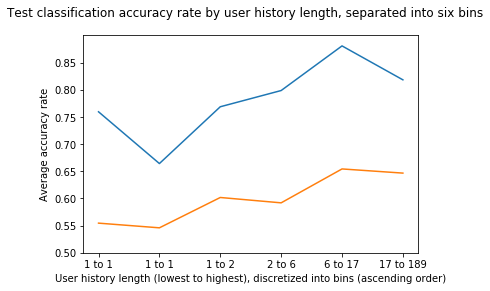

In [14]:
acc, auc, f1, precision, recall, bin_names, graph_results, priors_list = test_100(X_train,y_train,X_test,y_test, X_hist_len_test)

Acc: 0.7944569288389515
AUC: 0.8366890940384919
F1: 0.8669603400741603
Precision: 0.8172503969688296
Recall: 0.9235800344234082


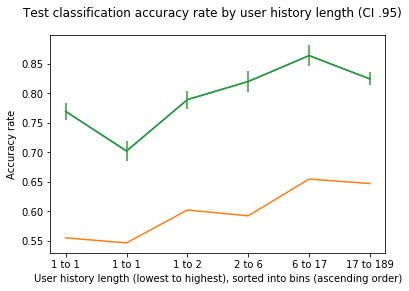

In [15]:
print("Acc:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)
plot_cis(bin_names, graph_results, priors_list)



